# exp126
移動平均線での異常値除去検討

In [86]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)

In [87]:
g1 = ['2020-05-14-US-MTV-1', '2020-05-14-US-MTV-2', '2020-05-21-US-MTV-1', '2020-05-21-US-MTV-2',
      '2020-05-29-US-MTV-1', '2020-05-29-US-MTV-2', '2020-06-04-US-MTV-1', '2020-06-05-US-MTV-1',
      '2020-06-05-US-MTV-2', '2020-06-11-US-MTV-1', '2020-07-08-US-MTV-1', '2020-07-17-US-MTV-1',
      '2020-07-17-US-MTV-2', '2020-08-03-US-MTV-1', '2020-08-06-US-MTV-2', '2020-09-04-US-SF-1',
      '2020-09-04-US-SF-2',  '2021-01-04-US-RWC-1', '2021-01-04-US-RWC-2',
      '2020-05-15-US-MTV-1', '2020-05-28-US-MTV-1', '2020-05-28-US-MTV-2', '2020-06-04-US-MTV-2',
      '2020-06-10-US-MTV-1', '2020-06-10-US-MTV-2', '2020-08-03-US-MTV-2', '2020-08-13-US-MTV-1',
      '2021-03-16-US-MTV-2']

g2 = ['2021-01-05-US-SVL-1', '2021-01-05-US-SVL-2', '2021-04-15-US-MTV-1', 
      '2021-03-25-US-PAO-1', '2021-04-02-US-SJC-1', '2021-04-08-US-MTV-1']

g3 = ['2021-03-10-US-SVL-1', '2021-04-26-US-SVL-1', '2021-04-26-US-SVL-2']

g4 = ['2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1', 
      '2021-03-16-US-RWC-2', '2021-04-21-US-MTV-1', '2021-04-28-US-MTV-2', '2021-04-29-US-MTV-2']

g5 = ['2021-04-22-US-SJC-1', '2021-04-28-US-SJC-1', '2021-04-29-US-SJC-2', 
      '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']

In [88]:
target = g1 + g2 + g3 + g4

In [89]:
ro_th = 50 # 相対移動距離をもとにした異常値除去の閾値
rog_th = 10 # ground_truthをもとにした異常値除去の閾値

# ground_truthをもとにした異常値除去を行うcollection
rog_target = ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3',
              '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1', '2021-03-16-US-RWC-2', '2021-04-28-US-MTV-2', '2021-04-29-US-MTV-2',
              '2021-04-26-US-SVL-2', '2021-03-10-US-SVL-1', '2021-04-26-US-SVL-1',
              '2021-04-21-US-MTV-1', '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1']

In [90]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [91]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [92]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [93]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [94]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [95]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [96]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [97]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [98]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

In [99]:
def update_baseline(df, rb):
    rb = rb.rename(columns={'latDeg':'latDeg_rb', 'lngDeg':'lngDeg_rb'})
    df = df.merge(rb[['millisSinceGpsEpoch', 'phone', 'latDeg_rb', 'lngDeg_rb']], on=['millisSinceGpsEpoch', 'phone'], how='left')

    idx = df[~df['latDeg_rb'].isnull()].index
    df.loc[idx, 'latDeg'] = df.loc[idx, 'latDeg_rb']
    df.loc[idx, 'lngDeg'] = df.loc[idx, 'lngDeg_rb']
    
    df.drop(columns=['latDeg_rb', 'lngDeg_rb'], inplace=True)
    
    return df

# 自前再構成baselineに更新

In [100]:
train, test, sub, gt = get_data()

In [101]:
train = update_baseline(train, pd.read_csv('../output/prep/baseline_g1_v001/result.csv'))
train = update_baseline(train, pd.read_csv('../output/prep/baseline_g2_v003/result.csv'))
train = update_baseline(train, pd.read_csv('../output/prep/baseline_g3_v003/result.csv'))
train = update_baseline(train, pd.read_csv('../output/prep/baseline_g4_v002/result.csv'))

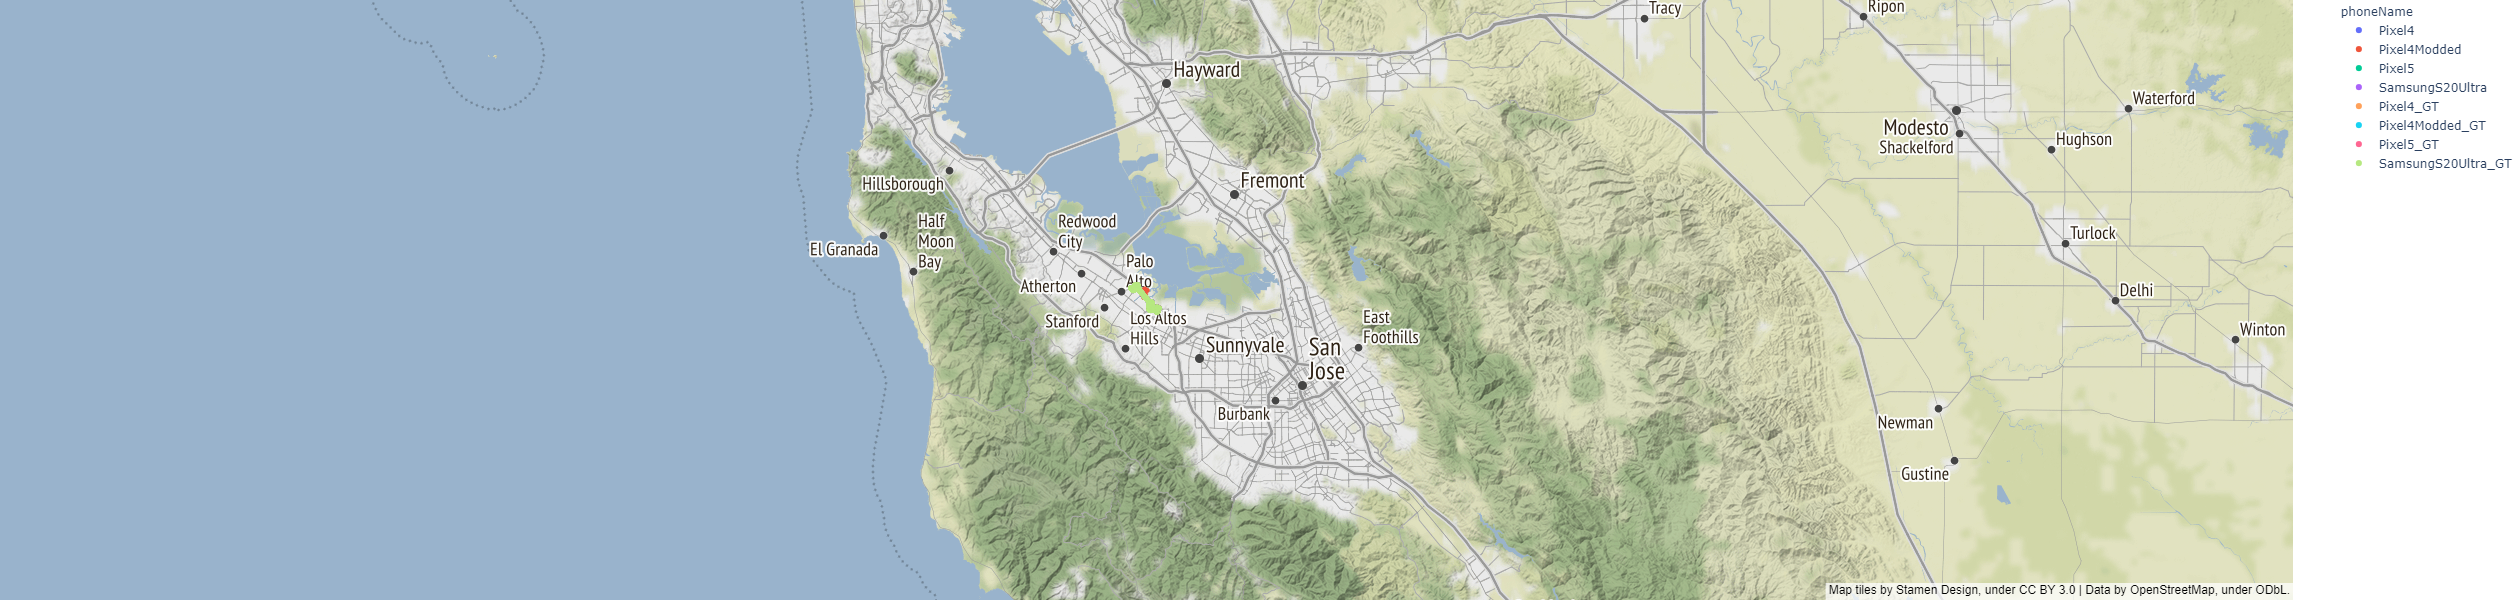

In [102]:
train_result(train).viz_map('2021-04-15-US-MTV-1', show_bl=False)

# 相対移動距離をもとにした外れ値除去

In [103]:
def add_distance_diff(df):
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev']] = np.nan
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next']] = np.nan
    
    return df

In [104]:
# reject outlier
train = add_distance_diff(train)
train.loc[((train['dist_prev'] > ro_th) & (train['dist_next'] > ro_th)), ['latDeg', 'lngDeg']] = np.nan
train.to_csv(OUTPUT + '/train_ro.csv', index=False)

# 移動平均をもとにした外れ値除去

In [105]:
def ro_based_on_rolling_mean(df, output_dir=None):
    phones = df['phone'].unique()
    for phone in phones:
        tmp = df[df['phone']==phone].copy()
        
        tmp['latDeg_roll'] = tmp['latDeg'].rolling(10, min_periods=3, center=True).mean().values
        tmp['latDeg_err'] = tmp['latDeg'] - tmp['latDeg_roll']
        tmp['latDeg_err_roll'] = tmp['latDeg_err'].rolling(2000, min_periods=3, center=True).mean().values
        tmp['latDeg_err_std'] = tmp['latDeg_err'].rolling(2000, min_periods=3, center=True).std().values
        tmp['latDeg_err_p3s'] = tmp['latDeg_err_roll'] + tmp['latDeg_err_std'] * 3
        tmp['latDeg_err_m3s'] = tmp['latDeg_err_roll'] - tmp['latDeg_err_std'] * 3
        
        tmp.loc[(tmp['latDeg_err']>tmp['latDeg_err_p3s'])|(tmp['latDeg_err']<tmp['latDeg_err_m3s']), 'ro'] = 1

        tmp['lngDeg_roll'] = tmp['lngDeg'].rolling(10, min_periods=3, center=True).mean().values
        tmp['lngDeg_err'] = tmp['lngDeg'] - tmp['lngDeg_roll']
        tmp['lngDeg_err_roll'] = tmp['lngDeg_err'].rolling(2000, min_periods=3, center=True).mean().values
        tmp['lngDeg_err_std'] = tmp['lngDeg_err'].rolling(2000, min_periods=3, center=True).std().values
        tmp['lngDeg_err_p3s'] = tmp['lngDeg_err_roll'] + tmp['lngDeg_err_std'] * 3
        tmp['lngDeg_err_m3s'] = tmp['lngDeg_err_roll'] - tmp['lngDeg_err_std'] * 3
        
        tmp.loc[(tmp['lngDeg_err']>tmp['lngDeg_err_p3s'])|(tmp['lngDeg_err']<tmp['lngDeg_err_m3s']), 'ro'] = 1
        
        ro_idx = tmp[tmp['ro']==1].index
        df.loc[ro_idx, ['latDeg', 'lngDeg']] = np.nan
        
        if output_dir is not None:
            os.makedirs(output_dir + '/latlng', exist_ok=True)
            os.makedirs(output_dir + '/coord', exist_ok=True)
            
            fig, axes = plt.subplots(figsize=(40, 20), nrows=4, sharex=True)
            axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['latDeg'], label='latDeg')
            axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['latDeg_roll'], label='latDeg_roll')
            axes[0].legend(loc='upper right')
            axes[0].grid(color='g', linestyle=':', linewidth=0.3)
            
            axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['lngDeg'], label='lngDeg')
            axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['lngDeg_roll'], label='lngDeg_roll')
            axes[1].legend(loc='upper right')
            axes[1].grid(color='g', linestyle=':', linewidth=0.3)
            
            axes[2].plot(tmp['millisSinceGpsEpoch'], tmp['latDeg_err'], label='latDeg_err')
            axes[2].plot(tmp['millisSinceGpsEpoch'], tmp['latDeg_err_roll'], label='latDeg_err_roll')
            axes[2].plot(tmp['millisSinceGpsEpoch'], tmp['latDeg_err_p3s'], label='latDeg_err_p3s')
            axes[2].plot(tmp['millisSinceGpsEpoch'], tmp['latDeg_err_m3s'], label='latDeg_err_m3s')
            axes[2].legend(loc='upper right')
            axes[2].grid(color='g', linestyle=':', linewidth=0.3)

            axes[3].plot(tmp['millisSinceGpsEpoch'], tmp['lngDeg_err'], label='lngDeg_err')
            axes[3].plot(tmp['millisSinceGpsEpoch'], tmp['lngDeg_err_roll'], label='lngDeg_err_roll')
            axes[3].plot(tmp['millisSinceGpsEpoch'], tmp['lngDeg_err_p3s'], label='lngDeg_err_p3s')
            axes[3].plot(tmp['millisSinceGpsEpoch'], tmp['lngDeg_err_m3s'], label='lngDeg_err_m3s')
            axes[3].legend(loc='upper right')
            axes[3].grid(color='g', linestyle=':', linewidth=0.3)
            
            fig.suptitle(phone, fontsize=16)
            fig.savefig(f'{output_dir}/latlng/{phone}.png')
            plt.close()
            
            ok = tmp[tmp['ro']!=1]
            ro = tmp[tmp['ro']==1]
            fig = plt.figure(figsize=(30,30))
            plt.scatter(ok['latDeg'], ok['lngDeg'],color='b')
            plt.scatter(ro['latDeg'], ro['lngDeg'],color='r')

            fig.suptitle(phone, fontsize=16)
            fig.savefig(f'{output_dir}/coord/{phone}.png')
            plt.close()
        
    return df

In [106]:
train = ro_based_on_rolling_mean(train, output_dir=f'{OUTPUT}/train')

In [107]:
test = ro_based_on_rolling_mean(train, output_dir=f'{OUTPUT}/test')